## Outlier Detection in Election Data Using Geospatial Analysis (Using Lagos state As Case Study)

### Introduction

In the recently concluded election (Nigeria presidential Elections), the Independent National Electoral Commission (INEC) has faced multiple legal challenges concerning the integrity and accuracy of the election results. Allegations of vote manipulation and irregularities have been widespread, prompting a thorough investigation into the matter. This project uncovers potential voting irregularities and ensure the transparency of the election results. This was achieved by identifying outlier polling units where the voting results deviate significantly from neighbouring units, indicating potential influences or rigging. 
The addresses were geocoded with Qgis software (A Free and Open Source Geographic Information System) 593 addresses were geocoded correctly by the software, using the MMQGIS plugin.

In [80]:
## Import necessary libraries

import pandas as pd
import geopandas
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt


In [221]:
# Load the original cross-checked data in
data = pd.read_csv("LAGOS_crosschecked.csv")

In [222]:
# checking the head of the dataset
data.head()

State    LGA              Ward       PU-Code  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-001   
1  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002   
2  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-004   
3  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-005   
4  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-006   

                                PU-Name  Accredited_Voters  Registered_Voters  \
0  ST. JOSEPH SECONDARY SCHOOL, MANGORO                120                744   
1                    15, SHOMIDE STREET                111                716   
2                   8, SEBIOTIMO STREET                108                843   
3                   6, SEBIOTIMO STREET                114                731   
4                   WITHIN OLABI SQUARE                 80                539   

   Results_Found  Transcription_Count  Result_Sheet_Stamped  \
0           True                   -1                 False   
1           True                   -1                 False   
2           True                   -1                 False   
3           True                   -1                 False   
4           True                   -1                 False   

   Result_Sheet_Corrected  Result_Sheet_Invalid  Result_Sheet_Unclear  \
0                    True                 False                 False   
1                   False                 False                 False   
2                    True                 False                 False   
3                    True                 False                 False   
4                   False                 False                 False   

  Result_Sheet_Unsigned  APC  LP  PDP  NNPP  \
0               UNKNOWN    0   0    0     0   
1               UNKNOWN    0   0    0     0   
2               UNKNOWN   31  57   11     0   
3               UNKNOWN   28  66    5     1   
4               UNKNOWN   24  28   16     1   

                                        Results_File  
0  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  
1  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  
2  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  
3  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  
4  https://inec-cvr-cache.s3.eu-west-1.amazonaws....

In [223]:
# Checking the null values of the dataset
data.isnull().sum()

State                     0
LGA                       0
Ward                      0
PU-Code                   0
PU-Name                   0
Accredited_Voters         0
Registered_Voters         0
Results_Found             0
Transcription_Count       0
Result_Sheet_Stamped      0
Result_Sheet_Corrected    0
Result_Sheet_Invalid      0
Result_Sheet_Unclear      0
Result_Sheet_Unsigned     0
APC                       0
LP                        0
PDP                       0
NNPP                      0
Results_File              0
dtype: int64

In [224]:
# creating an address column from "PU-name", "LGA", and "state for the openstreetmap API to use
data["Address"] = data["PU-Name"] + " " + data["LGA"] + " " + data["State"]

In [225]:
# Saving the data into a csv file
data.to_csv("new_lagos_data.csv", index=False)

In [226]:
data.head(2)

State    LGA              Ward       PU-Code  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-001   
1  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002   

                                PU-Name  Accredited_Voters  Registered_Voters  \
0  ST. JOSEPH SECONDARY SCHOOL, MANGORO                120                744   
1                    15, SHOMIDE STREET                111                716   

   Results_Found  Transcription_Count  Result_Sheet_Stamped  \
0           True                   -1                 False   
1           True                   -1                 False   

   Result_Sheet_Corrected  Result_Sheet_Invalid  Result_Sheet_Unclear  \
0                    True                 False                 False   
1                   False                 False                 False   

  Result_Sheet_Unsigned  APC  LP  PDP  NNPP  \
0               UNKNOWN    0   0    0     0   
1               UNKNOWN    0   0    0     0   

                                        Results_File  \
0  https://inec-cvr-cache.s3.eu-west-1.amazonaws....   
1  https://inec-cvr-cache.s3.eu-west-1.amazonaws....   

                                            Address  
0  ST. JOSEPH SECONDARY SCHOOL, MANGORO AGEGE LAGOS  
1                    15, SHOMIDE STREET AGEGE LAGOS

In [227]:
# Reload new dataset into the dataframe
data = pd.read_csv("new_lagos_data.csv")

In [202]:
# slicing the dataframe to use for geolocating in Qgis
# A total of 23 files were gotten from geolocation 
sample = data.iloc[9495:9994,:]

In [203]:
sample

State  ...                                           Addrress
9495  LAGOS  ...       PREMISES OF RCM AWOYAYA II IBEJU/LEKKI LAGOS
9496  LAGOS  ...      OPEN SPACE AT GBETU PHASE I IBEJU/LEKKI LAGOS
9497  LAGOS  ...  IN FRONT OF TEACHERS QUARTERS IRABOKO IBEJU/LE...
9498  LAGOS  ...       OPEN SPACE AT ABULE PARAPO IBEJU/LEKKI LAGOS
9499  LAGOS  ...  IN FRONT OF MAYFAIR GARDEN AWOYAYA IBEJU/LEKKI...
...     ...  ...                                                ...
9989  LAGOS  ...                    ODUYEMI/AFIZ STREET IKEJA LAGOS
9990  LAGOS  ...            OJULOWO/BAYO SHODIPO STREET IKEJA LAGOS
9991  LAGOS  ...                          OLAIDE TOMORI IKEJA LAGOS
9992  LAGOS  ...                  AWOLOWO WAY OTIGBA. I IKEJA LAGOS
9993  LAGOS  ...                 AWOLOWO WAY OTIGBA. II IKEJA LAGOS

[499 rows x 20 columns]

In [204]:
sample.to_csv("sample_26.csv",index=False)

In [228]:
# Loading all the geolacated data at once
import glob
import numpy as np
import os

In [229]:
# Getting the path of all geocoded results using glob.glob
glob.glob("C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result*.csv")

['C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_1.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_10.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_11.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_12.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_13.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_14.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_15.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_16.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_17.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_18.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_19.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result_2.csv',
 'C:\\Users\\TEMITOPE\\Desktop\\Data_Analy

In [9]:
# Reading all the files into a list of list
all_dfs = []

for one_filename in glob.glob("C:\\Users\\TEMITOPE\\Desktop\\Data_Analyst\\Stage_1\\Geocode\\result*.csv"):
    print(f"Loading {one_filename}")
    new_df = pd.read_csv(one_filename)
    all_dfs.append(new_df)

Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_1.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_10.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_11.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_12.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_13.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_14.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_15.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_16.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_17.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_18.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_19.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_2.csv
Loading C:\Users\TEMITOPE\Desktop\Data_Analyst\Stage_1\Geocode\result_22.csv
L

In [230]:
len(all_dfs)

23

In [231]:
# Concatenating all the files into a single DataFrame
df = pd.concat(all_dfs)

In [232]:
# 592 Addresses were successfully geocoded
df.shape

(592, 26)

In [233]:
# Cleaning the 'latlong' column
array = df[['latlong']].values

In [235]:
array[2]

array(['6.6115629,3.3269877'], dtype=object)

In [236]:
# Turning the latlong array to list 
list = array.tolist()

In [237]:
list[0]

['6.611471,3.3278433']

In [238]:
# iterating through the list of latlong for splitting into different lists
lat = []
long = []
for i in list:
    lat.append(i[0].split(",")[0])
    long.append(i[0].split(",")[1])

In [239]:
# Assigning the list back to the dataframe
df["lat"] = lat
df["long"] = long

In [240]:
df.head(2)

State    LGA              Ward       PU-Code              PU-Name  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002   15, SHOMIDE STREET   
1  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-004  8, SEBIOTIMO STREET   

   Accredited  Registered  Results_Fo  Transcript  Result_She  ...  \
0         111         716        True          -1       False  ...   
1         108         843        True          -1       False  ...   

                                          Results_Fi  \
0  https://inec-cvr-cache.s3.eu-west-1.amazonaws....   
1  https://inec-cvr-cache.s3.eu-west-1.amazonaws....   

                          Addrress  result_num     osm_id  \
0   15, SHOMIDE STREET AGEGE LAGOS           0  144455430   
1  8, SEBIOTIMO STREET AGEGE LAGOS           0  570278064   

                                        display_na  category         type  \
0    Shomide Street, Agege, Lagos, 100282, Nigeria   highway  residential   
1  Sebiotimo Street, Agege, Lagos, 100282, Nigeria   highway  residential   

               latlong        lat       long  
0   6.611471,3.3278433   6.611471  3.3278433  
1  6.6115629,3.3269877  6.6115629  3.3269877  

[2 rows x 28 columns]

In [241]:
# choosing the relevant column for analysis
df_1 = df[['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name','Accredited', 'APC', 'LP', 'PDP', 'NNPP','lat', 'long']]

In [242]:
df_1.head(1)

State    LGA              Ward       PU-Code             PU-Name  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002  15, SHOMIDE STREET   

   Accredited  APC  LP  PDP  NNPP       lat       long  
0         111    0   0    0     0  6.611471  3.3278433

### Geospatial Analysis

In [243]:
# using geopandas to convert long and lat to points
df_geo = GeoDataFrame(df_1, geometry = geopandas.points_from_xy(df_1.long, df_1.lat))
df_geo.head(1)

State    LGA              Ward       PU-Code             PU-Name  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002  15, SHOMIDE STREET   

   Accredited  APC  LP  PDP  NNPP       lat       long  \
0         111    0   0    0     0  6.611471  3.3278433   

                  geometry  
0  POINT (3.32784 6.61147)

In [119]:
# importing GeoDataFrame from geopandas
from geopandas import GeoDataFrame

In [246]:
# Plotting the coordinates
cities_data = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))

C:\Users\TEMITOPE\AppData\Local\Temp\ipykernel_7704\772501978.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cities_data = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))


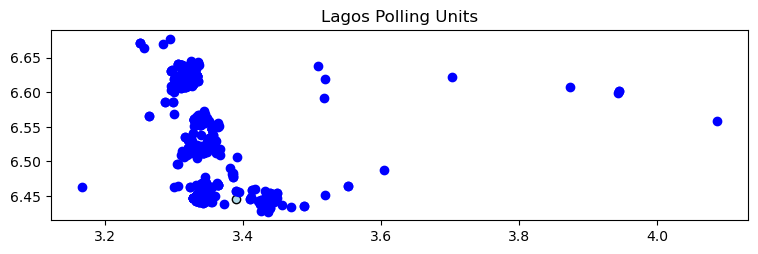

In [248]:
plt.rcParams['figure.figsize'] = [9, 6]
axis = cities_data[cities_data.name == 'Lagos'].plot(color = 'lightblue', edgecolor='black')

df_geo.plot(ax= axis, color = 'blue')
plt.title("Lagos Polling Units");

In [249]:
# reprojecting the points for spatial analysis
reproj = df_geo.set_crs('EPSG:32631').to_crs('EPSG:32631')

In [250]:
buffered = reproj.copy()

In [146]:
## Setting a radius of 1000m(1km) for neighbouring polling units
radius = 1000
# Applying the distance
buffer_geometry = reproj.buffer(
    radius, resolution=5, cap_style=1, join_style=1, mitre_limit=2)

In [149]:
buffered['geometry'] = buffer_geometry

In [251]:
# Buffered dataset
buffered.head(1)

State    LGA              Ward       PU-Code             PU-Name  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002  15, SHOMIDE STREET   

   Accredited  APC  LP  PDP  NNPP       lat       long             geometry  
0         111    0   0    0     0  6.611471  3.3278433  POINT (3.328 6.611)

In [156]:
buffered.head(1)

State    LGA              Ward       PU-Code             PU-Name  \
0  LAGOS  AGEGE  ISALE/IDIMANGORO  24-01-01-002  15, SHOMIDE STREET   

   Accredited  APC  LP  PDP  NNPP       lat       long  \
0         111    0   0    0     0  6.611471  3.3278433   

                                            geometry  dissolvefield  
0  POLYGON ((1003.328 6.611, 954.384 -302.406, 81...              1

### Outlier Detection

In [270]:
# Calculating the outlier score in the dataset for each party using the interquantile range method(IQR)

Q1 = buffered.APC.quantile(0.25)
Q3 = buffered.APC.quantile(0.75)
Q1, Q3
IQR = Q3 - Q1
IQR

min_threshold_apc = Q1 - 1.5*IQR
max_threshold_apc = Q3 + 1.5*IQR
print(min_threshold_apc, max_threshold_apc)

buffered[buffered["APC"] > max_threshold_apc].shape


-26.5 105.5


(6, 13)

In [272]:
# outliers for LP
Q1 = buffered.LP.quantile(0.25)
Q3 = buffered.LP.quantile(0.75)
Q1, Q3
IQR = Q3 - Q1
IQR

min_threshold_lp = Q1 - 1.5*IQR
max_threshold_lp = Q3 + 1.5*IQR
min_threshold_lp, max_threshold_lp

buffered[buffered["LP"] > max_threshold_lp].shape

(36, 13)

In [273]:
# Outlier detection for PDP
Q1 = buffered.PDP.quantile(0.25)
Q3 = buffered.PDP.quantile(0.75)
Q1, Q3
IQR = Q3 - Q1
IQR

min_threshold_pdp = Q1 - 1.5*IQR
max_threshold_pdp = Q3 + 1.5*IQR
min_threshold_pdp, max_threshold_pdp

buffered[buffered["PDP"] > max_threshold_pdp].shape

(18, 13)

In [274]:
# outlier detection for NNPP
Q1 = buffered.NNPP.quantile(0.25)
Q3 = buffered.NNPP.quantile(0.75)
Q1, Q3
IQR = Q3 - Q1
IQR

min_threshold_nnpp = Q1 - 1.5*IQR
max_threshold_nnpp = Q3 + 1.5*IQR
min_threshold_nnpp, max_threshold_nnpp

buffered[buffered["NNPP"] > max_threshold_nnpp].shape

(39, 13)

In [275]:
# Sorting dataset by outlier(APC)
outlier_apc = buffered[(buffered.APC < min_threshold_apc) | (buffered.APC > max_threshold_apc)]

In [276]:
outlier_apc.shape

(6, 13)

In [252]:
# cities_data = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))

# axis = cities_data[cities_data.name == 'Lagos'].plot(color = 'lightblue', edgecolor='black')

# outlier_apc.plot(ax= axis, color = 'black')
# plt.title("Lagos Polling Units");

In [277]:
# Sorting dataset by outlier(LP)
outlier_lp = buffered[(buffered.LP < min_threshold_lp) | (buffered.LP > max_threshold_lp)]

In [278]:
outlier_lp.shape

(36, 13)

In [279]:
# Sorting dataset by outlier(PDP)
outlier_pdp = buffered[(buffered.PDP < min_threshold_pdp) | (buffered.PDP > max_threshold_pdp)]

In [280]:
outlier_pdp.shape

(18, 13)

In [281]:
# Sorting dataset by outlier(NNPP)
outlier_nnpp = buffered[(buffered.NNPP < min_threshold_nnpp) | (buffered.NNPP > max_threshold_nnpp)]

In [282]:
outlier_nnpp.shape

(39, 13)

In [296]:
all_outliers = pd.concat([outlier_apc, outlier_lp, outlier_nnpp, outlier_pdp])
all_outliers.to_csv("Outliers.csv")

In [284]:
all_outliers.sort_values(by=["APC", "LP", "PDP", "NNPP"], ascending=False).head()

State      LGA                              Ward       PU-Code  \
1  LAGOS  IKORODU                        IGBOGBO II  24-12-10-007   
1  LAGOS      EPE                           ITOIKIN  24-07-19-010   
1  LAGOS      EPE                           ITOIKIN  24-07-19-010   
0  LAGOS    APAPA                       IJORA-OLOYE  24-05-05-006   
3  LAGOS    APAPA  AFOLABI ALASIA STR. AND ENVIRONS  24-05-08-017   

                         PU-Name  Accredited  APC  LP  PDP  NNPP        lat  \
1  U.A.M.C. PRY. SCHOOL, IGBOGBO         243  133  78   15     0  6.5913074   
1                 TEMU VILLAGE I           0  125  62   13     4   6.602061   
1                 TEMU VILLAGE I           0  125  62   13     4   6.602061   
0                ODOFIN STREET I         138  121   2   13     0  6.4647956   
3                GASKIYA ROAD II         158  113  12   10     0  6.4664961   

        long             geometry  
1  3.5171269  POINT (3.517 6.591)  
1   3.943919  POINT (3.944 6.602)  
1   3.943919  POINT (3.944 6.602)  
0  3.3457366  POINT (3.346 6.465)  
3  3.3633259  POINT (3.363 6.466)

<BarContainer object of 99 artists>

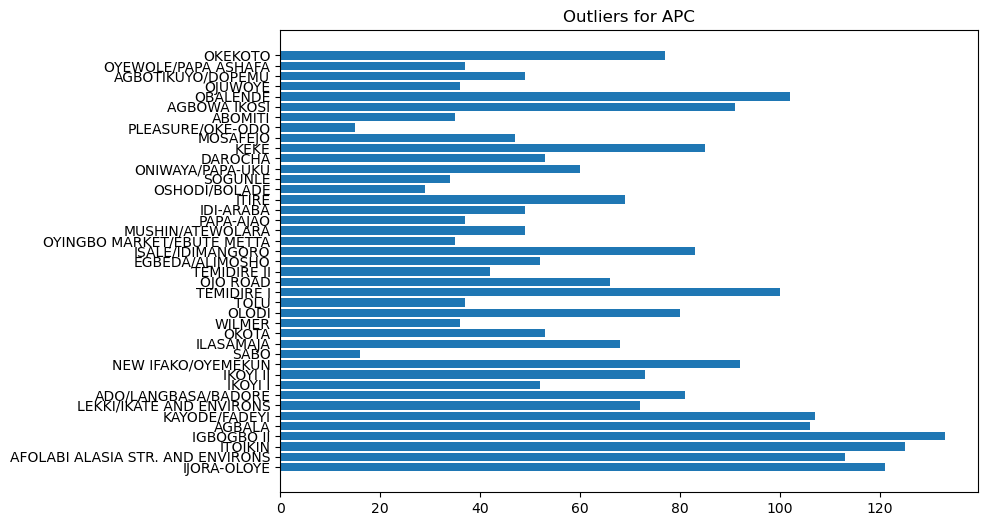

In [289]:
plt.title("Outliers for APC")
plt.barh(all_outliers["Ward"], all_outliers["APC"])

<BarContainer object of 99 artists>

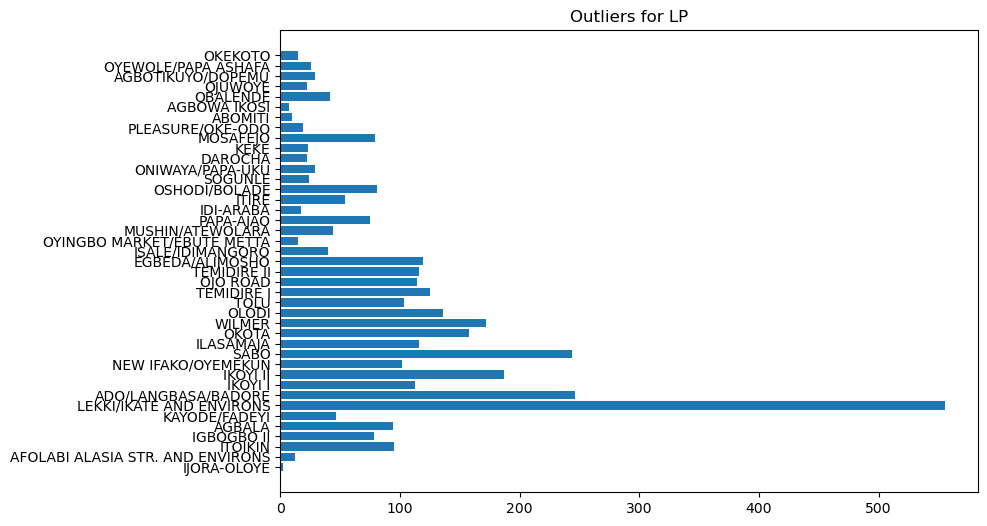

In [290]:
plt.title("Outliers for LP")
plt.barh(all_outliers["Ward"], all_outliers["LP"])

Igbogbo 11 ward seems to have thehighest outlier for APC, for LP it Lekki/ikate ward, for PDP its Abomiti ward and for NNPP it the idi araba ward

<BarContainer object of 99 artists>

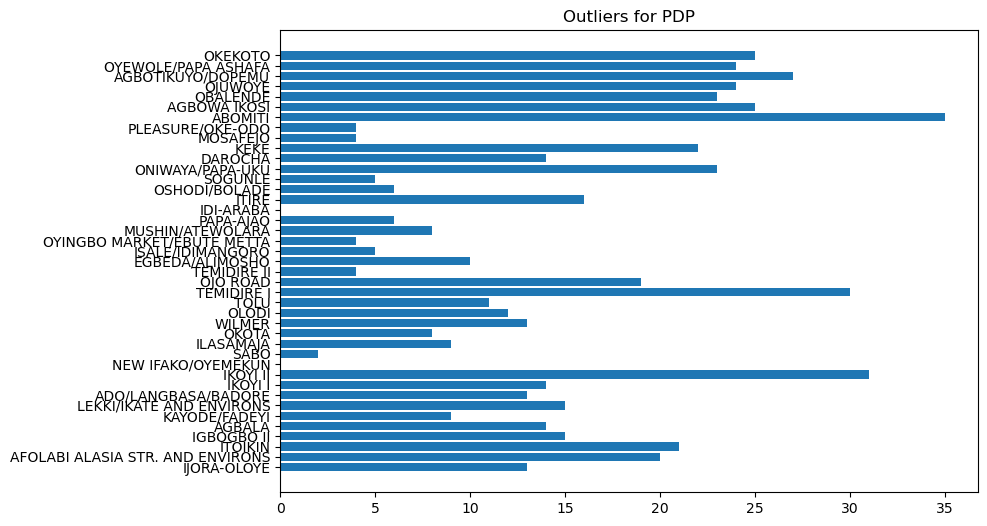

In [291]:
plt.title("Outliers for PDP")
plt.barh(all_outliers["Ward"], all_outliers["PDP"])

<BarContainer object of 99 artists>

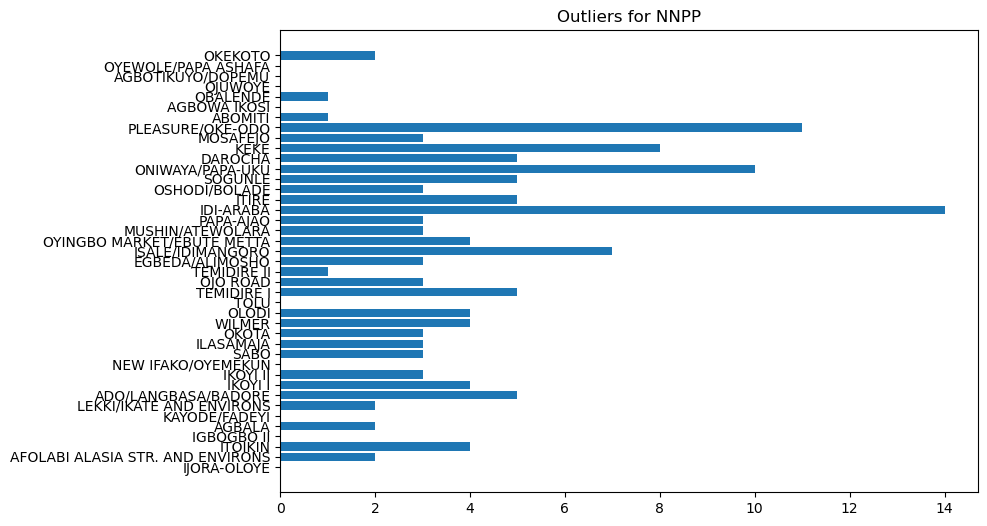

In [292]:
plt.title("Outliers for NNPP")
plt.barh(all_outliers["Ward"], all_outliers["NNPP"])